# Data Preprocessing and Feature Selection

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Features Rank

Features Rank:
gold_diff            0.107041
red_gold             0.060929
blue_gold            0.056376
cs_diff              0.049652
death_diff           0.048492
kill_diff            0.045583
red_mean_level       0.041213
blue_mean_level      0.039930
diff_mean_level      0.039675
red_cs               0.038463
blue_cs              0.037949
assist_diff          0.034812
wards_placed_diff    0.033535
blue_wards_placed    0.030969
red_wards_placed     0.028850
dtype: float64


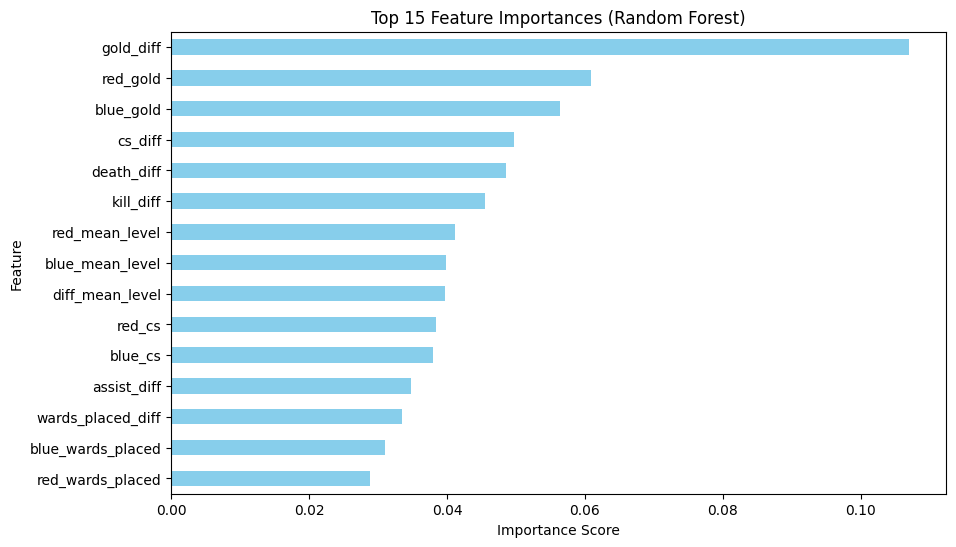

In [17]:

df = pd.read_csv("merged_match_data_ready.csv")
X = df.drop(columns=["target"])
y = df["target"]


rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Features Rank:")
print(importances.head(15))


top_n = 15
plt.figure(figsize=(10, 6))
importances.head(top_n).plot(kind="barh", color="skyblue")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()





Feature correlation heatmap

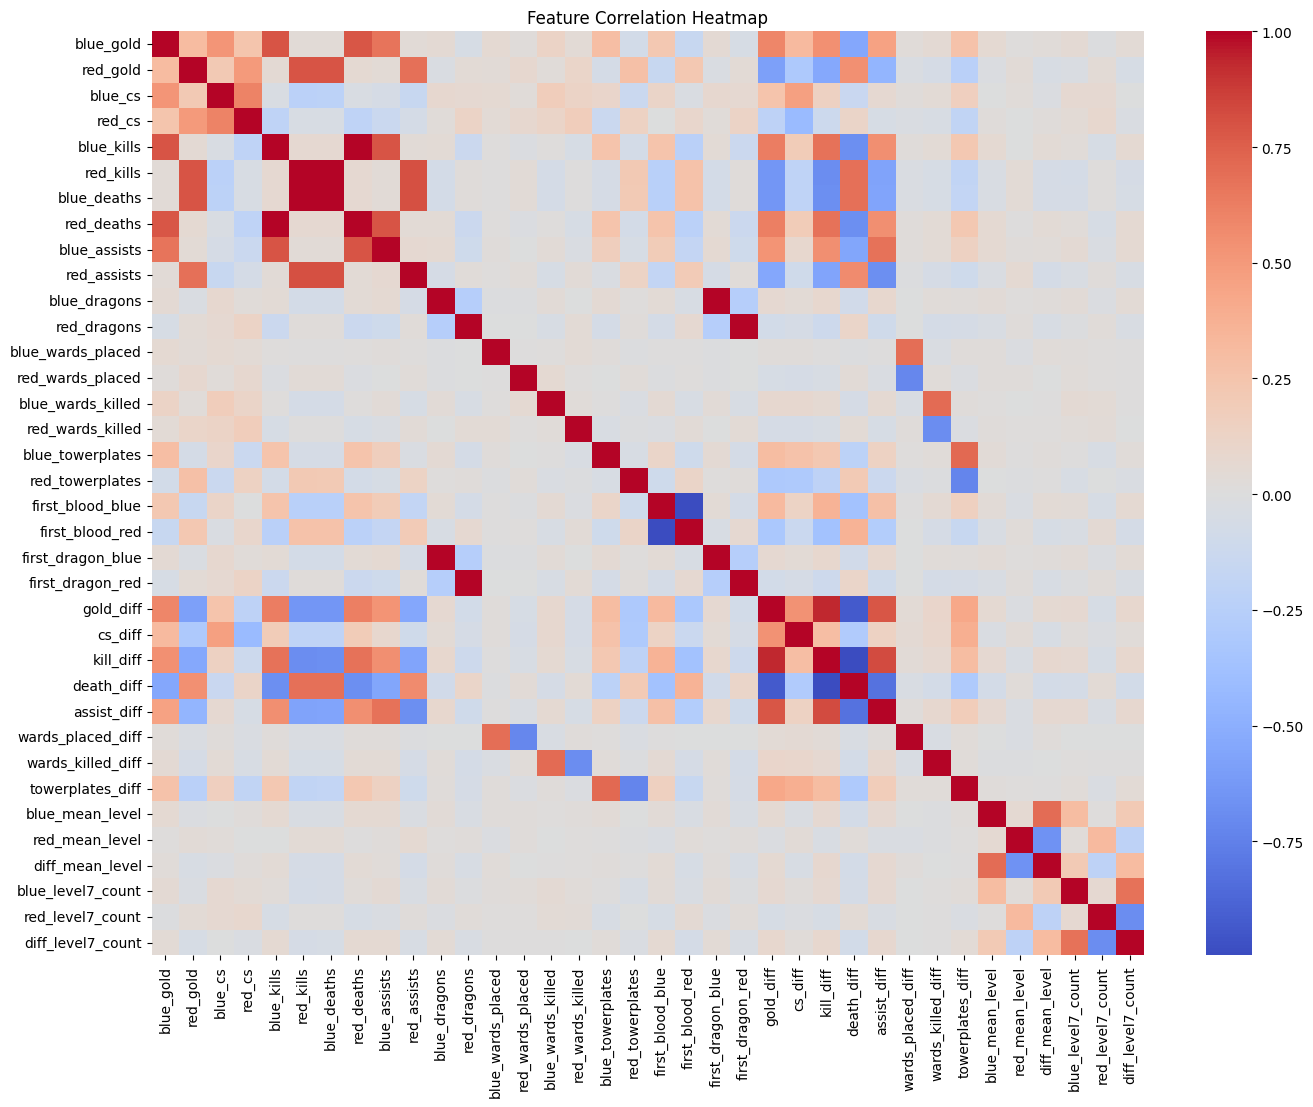

>= 0.85 Features: [('blue_kills', 'red_deaths', np.float64(0.9970051076015949)), ('red_kills', 'blue_deaths', np.float64(0.9968270624546316)), ('blue_deaths', 'red_kills', np.float64(0.9968270624546316)), ('red_deaths', 'blue_kills', np.float64(0.9970051076015949)), ('blue_dragons', 'first_dragon_blue', np.float64(1.0)), ('red_dragons', 'first_dragon_red', np.float64(1.0)), ('first_blood_blue', 'first_blood_red', np.float64(-0.9904650032961594)), ('first_blood_red', 'first_blood_blue', np.float64(-0.9904650032961594)), ('first_dragon_blue', 'blue_dragons', np.float64(1.0)), ('first_dragon_red', 'red_dragons', np.float64(1.0)), ('gold_diff', 'kill_diff', np.float64(0.9304909125392392)), ('gold_diff', 'death_diff', np.float64(-0.9266413866376395)), ('kill_diff', 'gold_diff', np.float64(0.9304909125392392)), ('kill_diff', 'death_diff', np.float64(-0.9966590908248597)), ('death_diff', 'gold_diff', np.float64(-0.9266413866376395)), ('death_diff', 'kill_diff', np.float64(-0.9966590908248597)

In [18]:


selected_features = [
    'blue_gold', 'red_gold', 'blue_cs', 'red_cs', 'blue_kills', 'red_kills',
    'blue_deaths', 'red_deaths', 'blue_assists', 'red_assists',
    'blue_dragons', 'red_dragons', 'blue_wards_placed', 'red_wards_placed',
    'blue_wards_killed', 'red_wards_killed', 'blue_towerplates', 'red_towerplates',
    'first_blood_blue', 'first_blood_red', 'first_dragon_blue', 'first_dragon_red',
    'gold_diff', 'cs_diff', 'kill_diff', 'death_diff', 'assist_diff',
    'wards_placed_diff', 'wards_killed_diff', 'towerplates_diff',
    'blue_mean_level', 'red_mean_level', 'diff_mean_level',
    'blue_level7_count', 'red_level7_count', 'diff_level7_count'
]
corr_matrix = df[selected_features].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()
high_corr = [(i, j, corr_matrix.loc[i, j]) for i in corr_matrix.columns for j in corr_matrix.columns 
             if i != j and abs(corr_matrix.loc[i, j]) > 0.85]
print(">= 0.85 Features:", high_corr)


Further feature processing

In [19]:

df = pd.read_csv("merged_match_data_ready.csv")

zero_var_candidates = ["blue_heralds", "red_heralds", "herald_diff", "first_tower_blue", "first_tower_red", "death_diff"]
drop_cols = [c for c in zero_var_candidates if c in df.columns]
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)


feature_cols = []
diff_cols = [c for c in df.columns if c.endswith("_diff") and c != "death_diff"]
feature_cols.extend(diff_cols)
if "first_blood_blue" in df.columns and "first_blood_red" in df.columns:
    df["firstBlood_diff"] = df["first_blood_blue"] - df["first_blood_red"]
    df.drop(columns=["first_blood_blue", "first_blood_red"], inplace=True)
    feature_cols.append("firstBlood_diff")
if "first_dragon_blue" in df.columns and "first_dragon_red" in df.columns:
    df["firstDragon_diff"] = df["first_dragon_blue"] - df["first_dragon_red"]
    df.drop(columns=["first_dragon_blue", "first_dragon_red"], inplace=True)
    feature_cols.append("firstDragon_diff")
mastery_diff_cols = [c for c in ["diff_mean_level", "diff_level7_count"] if c in df.columns]
feature_cols.extend(mastery_diff_cols)
feature_cols = sorted(set(feature_cols))

X = df[feature_cols].copy()
y = df["target"].astype(int)

out_train = pd.concat([X, y.rename("target")], axis=1)
out_train.to_csv("dataset_diff_first_mastery.csv", index=False, encoding="utf-8")

cols_with_id = (["matchId"] if "matchId" in df.columns else []) + feature_cols + ["target"]
df[cols_with_id].to_csv("dataset_diff_first_mastery_with_id.csv", index=False, encoding="utf-8")


df = pd.read_csv("dataset_diff_first_mastery.csv")


Evaluation Function

In [20]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, classification_report,
    roc_curve, auc, confusion_matrix
)

def evaluate_scores(y_pred_labels, y_pred_probs, y_true):
    print(f"Accuracy Score: {accuracy_score(y_true, y_pred_labels):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_probs):.4f}")
    print(f"Precision Score: {precision_score(y_true, y_pred_labels):.4f}")
    print(f"Recall Score: {recall_score(y_true, y_pred_labels):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred_labels):.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred_labels, digits=4))

def plot_roc_curve(y_pred_probs, y_true, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6), dpi=120)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def show_confusion(trained_model, X_eval, y_true, y_pred_labels):
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred_labels)
    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.matshow(conf_mat, cmap="Blues", alpha=0.7)
    # fig.colorbar(cax)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center', fontsize=12)

    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Divide the test set

In [21]:

X = df.drop("target", axis=1)
y = df["target"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Logistic regression

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Accuracy Score: 0.7228
ROC AUC Score: 0.7902
Precision Score: 0.7428
Recall Score: 0.7084
F1 Score: 0.7252

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.7033    0.7381    0.7203       546
           1     0.7428    0.7084    0.7252       583

    accuracy                         0.7228      1129
   macro avg     0.7231    0.7233    0.7227      1129
weighted avg     0.7237    0.7228    0.7228      1129



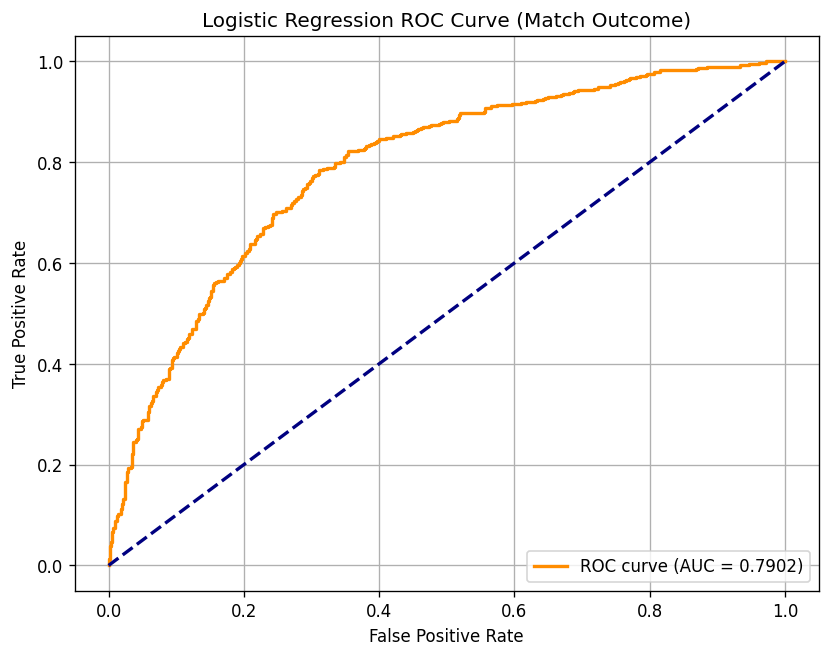

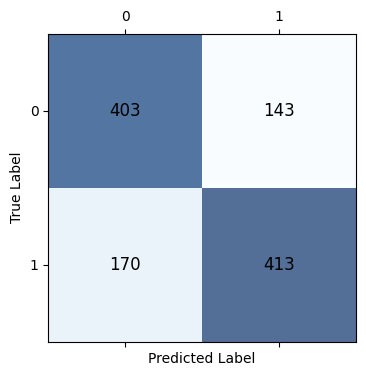

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))
])


param_grid = [
    {"clf__solver": ["liblinear"], "clf__penalty": ["l1", "l2"], "clf__C": [0.01, 0.1, 1, 10, 100]},
    {"clf__solver": ["lbfgs", "saga"], "clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10, 100]}
]

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

gs_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs_lr.fit(x_train, y_train)

best_lr = gs_lr.best_estimator_   
print("Best Params:", gs_lr.best_params_)

y_pred_lr = best_lr.predict(x_test)
y_prob_lr = best_lr.predict_proba(x_test)[:, 1]

evaluate_scores(y_pred_lr, y_prob_lr, y_test)
plot_roc_curve(y_prob_lr, y_test, "Logistic Regression ROC Curve (Match Outcome)")
show_confusion(best_lr, x_test, y_test, y_pred_lr)




Generate feature histogram

gold_diff            1.131231
firstDragon_diff     0.168642
diff_level7_count    0.126910
cs_diff              0.093332
firstBlood_diff     -0.019651
kill_diff            0.018533
assist_diff         -0.013002
towerplates_diff    -0.003635
diff_mean_level     -0.001621
wards_killed_diff    0.000000
wards_placed_diff    0.000000
dtype: float64

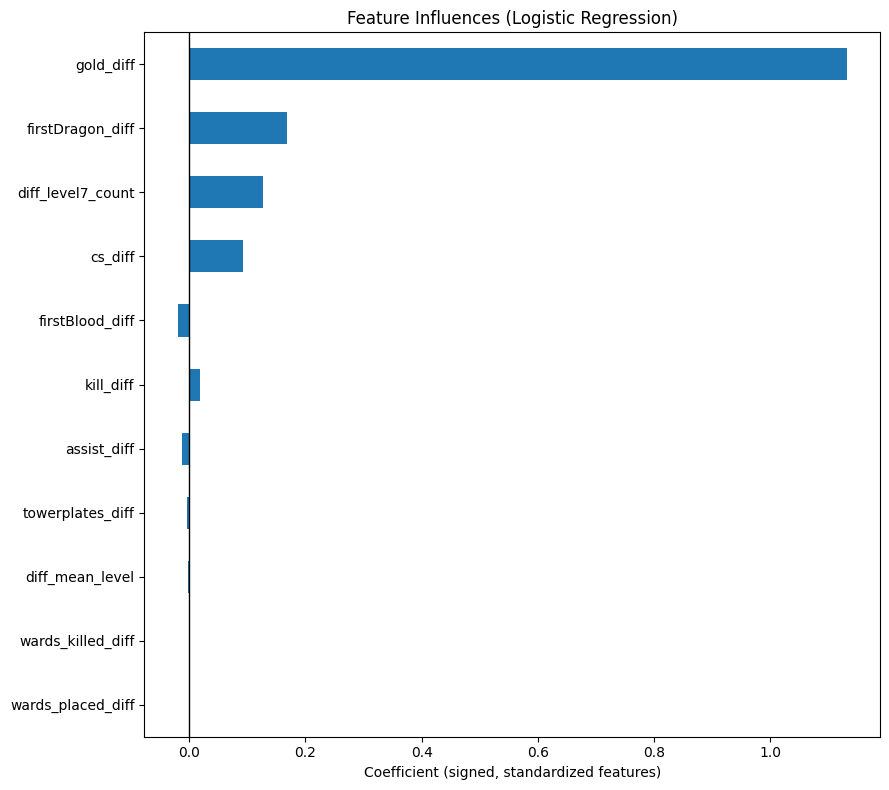

In [23]:
coefs = best_lr.named_steps["clf"].coef_.ravel()
feat_names = X.columns

coef_s = pd.Series(coefs, index=feat_names)
coef_sorted = coef_s.reindex(coef_s.abs().sort_values(ascending=False).index)

display(coef_sorted.head(20))

topN = 20
plt.figure(figsize=(9, max(6, topN * 0.4)))
coef_sorted.head(topN)[::-1].plot(kind="barh")
plt.axvline(0, color="black", linewidth=1)
plt.title("Feature Influences (Logistic Regression)")
plt.xlabel("Coefficient (signed, standardized features)")
plt.tight_layout()
plt.show()


Naive Bayes

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters Found: {'alpha': np.float64(10.0), 'fit_prior': True}
Accuracy Score: 0.7033
ROC AUC Score: 0.7599
Precision Score: 0.7168
Recall Score: 0.7033
F1 Score: 0.7100

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.6894    0.7033    0.6963       546
           1     0.7168    0.7033    0.7100       583

    accuracy                         0.7033      1129
   macro avg     0.7031    0.7033    0.7031      1129
weighted avg     0.7035    0.7033    0.7033      1129



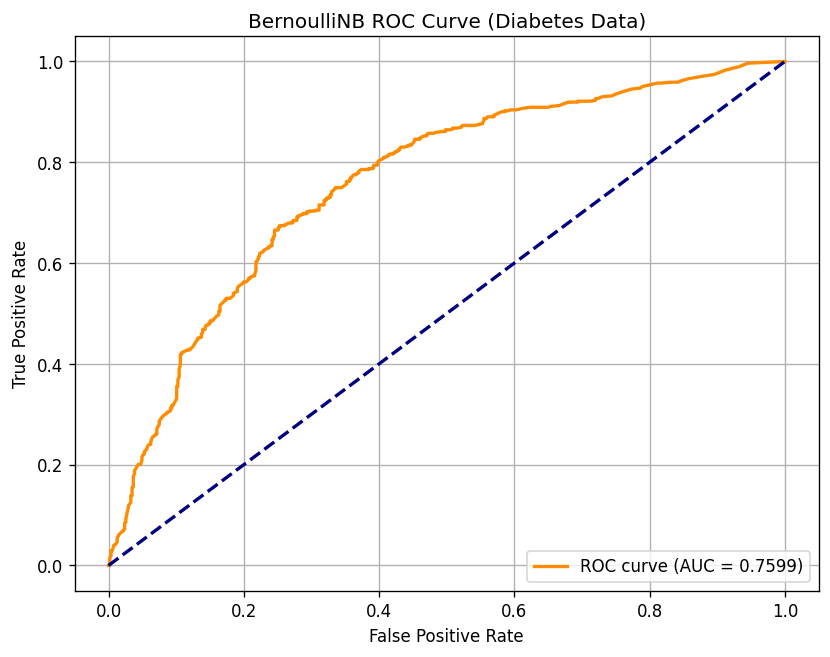

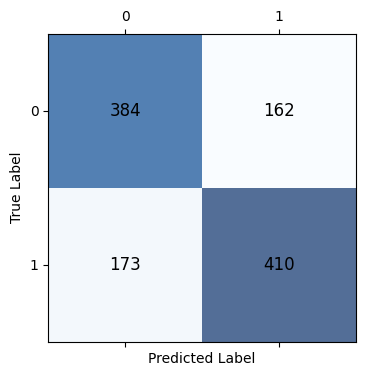

In [24]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV


param_grid = {
    'alpha': np.logspace(-3, 1, 10),  
    'fit_prior': [True, False]
}


bnb_model = BernoulliNB()


GS = GridSearchCV(
    estimator=bnb_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)


GS.fit(x_train, y_train)
print("Best Parameters Found:", GS.best_params_)


best_bnb = BernoulliNB(**GS.best_params_)
best_bnb.fit(x_train, y_train)


y_pred_bys = best_bnb.predict(x_test)
y_prob_bys = best_bnb.predict_proba(x_test)[:, 1]

evaluate_scores(y_pred_bys, y_prob_bys, y_test)
plot_roc_curve(y_prob_bys, y_test, 'BernoulliNB ROC Curve (Diabetes Data)')
show_confusion(best_bnb, x_test, y_test, y_pred_bys)

Random Forest

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Best CV ROC AUC: 0.7697265159460486
Accuracy Score: 0.7139
ROC AUC Score: 0.7807
Precision Score: 0.7218
Recall Score: 0.7256
F1 Score: 0.7237

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.7053    0.7015    0.7034       546
           1     0.7218    0.7256    0.7237       583

    accuracy                         0.7139      1129
   macro avg     0.7136    0.7135    0.7135      1129
weighted avg     0.7139    0.7139    0.7139      1129



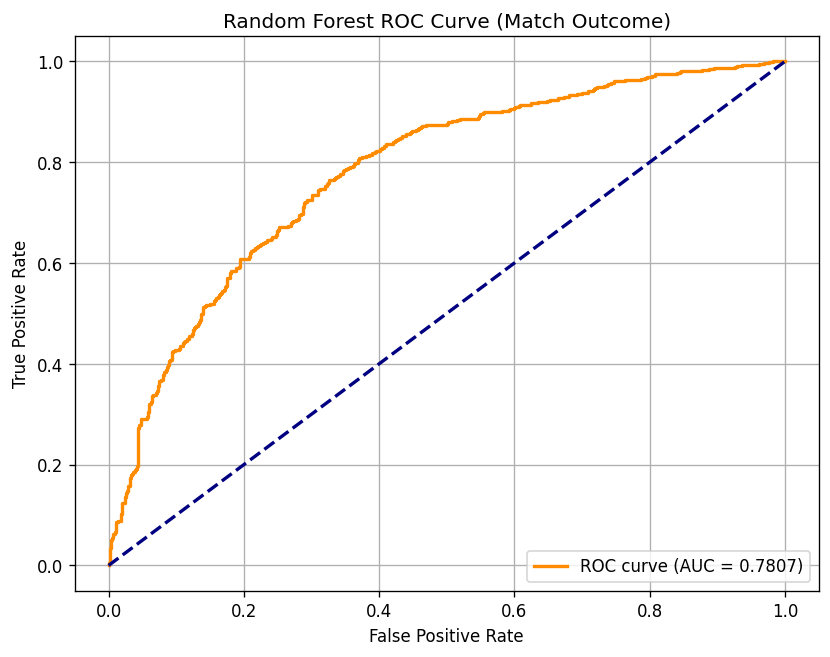

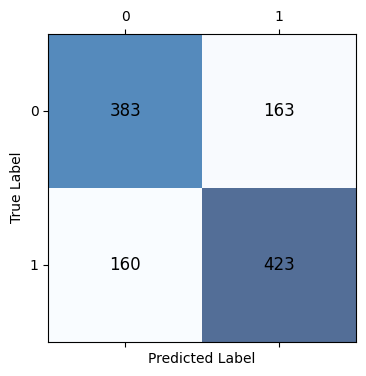

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_base = RandomForestClassifier(class_weight="balanced", random_state=42)


param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]  
}

grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(x_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

best_rf = grid.best_estimator_
y_pred_forest = best_rf.predict(x_test)
y_prob_forest = best_rf.predict_proba(x_test)[:, 1]

evaluate_scores(y_pred_forest, y_prob_forest, y_test)
plot_roc_curve(y_prob_forest, y_test, "Random Forest ROC Curve (Match Outcome)")
show_confusion(best_rf, x_test, y_test, y_pred_forest)



SVM

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\DODOO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best Parameters Found for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 5000}
Best CV ROC AUC: 0.7531774942816004
Accuracy Score: 0.7174
ROC AUC Score: 0.7698
Precision Score: 0.7383
Recall Score: 0.7015
F1 Score: 0.7194

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.6974    0.7344    0.7154       546
           1     0.7383    0.7015    0.7194       583

    accuracy                         0.7174      1129
   macro avg     0.7178    0.7180    0.7174      1129
weighted avg     0.7185    0.7174    0.7175      1129



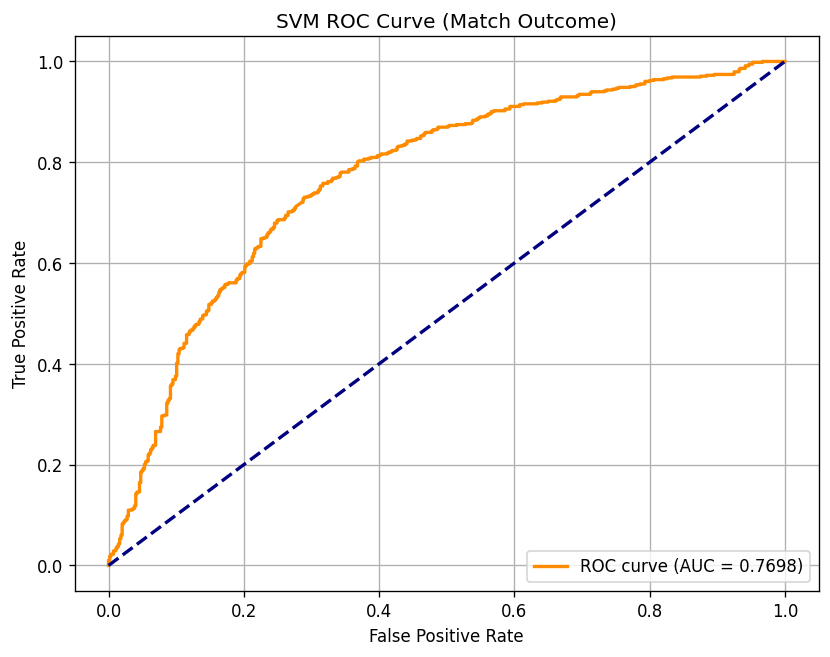

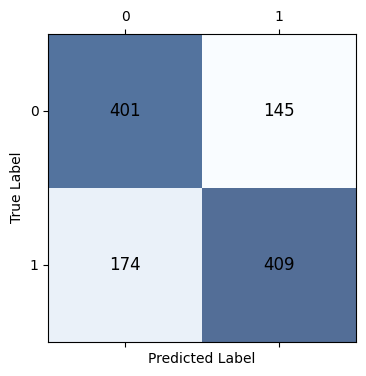

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


svm_model = SVC(probability=True, class_weight="balanced", random_state=42)

# 参数网格
param_grid_svm = {
    "C": [0.1, 1, 10],            
    "kernel": ["linear", "rbf"], 
    "gamma": ["scale", "auto"],  
    "max_iter": [5000]           
}

grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid_search_svm.fit(x_train, y_train)
print("Best Parameters Found for SVM:", grid_search_svm.best_params_)
print("Best CV ROC AUC:", grid_search_svm.best_score_)


best_svm = grid_search_svm.best_estimator_


y_pred_svm = best_svm.predict(x_test)
y_prob_svm = best_svm.predict_proba(x_test)[:, 1]

evaluate_scores(y_pred_svm, y_prob_svm, y_test)
plot_roc_curve(y_prob_svm, y_test, "SVM ROC Curve (Match Outcome)")
show_confusion(best_svm, x_test, y_test, y_pred_svm)


XGBOOST

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters Found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy Score: 0.7272
ROC AUC Score: 0.7853
Precision Score: 0.7152
Recall Score: 0.7839
F1 Score: 0.7480

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.7429    0.6667    0.7027       546
           1     0.7152    0.7839    0.7480       583

    accuracy                         0.7272      1129
   macro avg     0.7290    0.7253    0.7253      1129
weighted avg     0.7286    0.7272    0.7261      1129



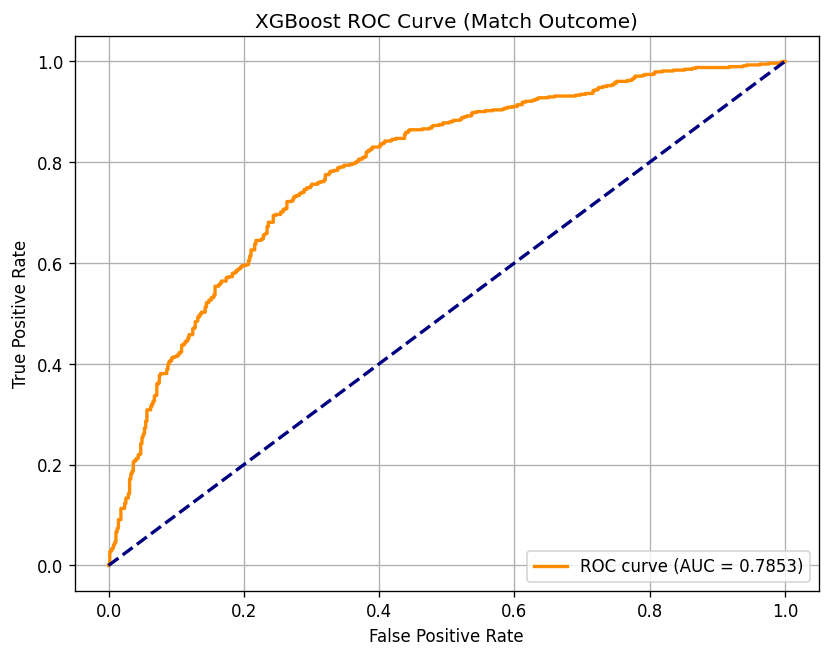

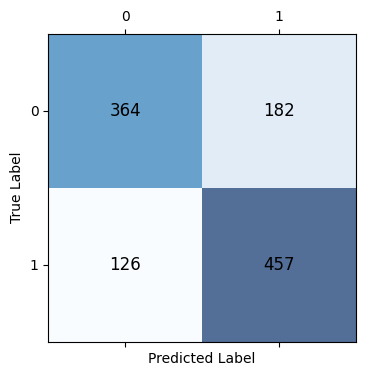

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
XGboost_model = XGBClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=XGboost_model,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)
print("Best Parameters Found:", grid_search.best_params_)

best_xgb = XGBClassifier(**grid_search.best_params_, random_state=42)
best_xgb.fit(x_train, y_train)

y_pred_XGB = best_xgb.predict(x_test)
y_prob_XGB = best_xgb.predict_proba(x_test)[:, 1]

evaluate_scores(y_pred_XGB, y_prob_XGB, y_test)
plot_roc_curve(y_prob_XGB, y_test, 'XGBoost ROC Curve (Match Outcome)')
show_confusion(best_xgb, x_test, y_test, y_pred_XGB)


Decision Tree

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters Found: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7, 'splitter': 'random'}
Accuracy Score: 0.6732
ROC AUC Score: 0.7540
Precision Score: 0.6890
Recall Score: 0.6690
F1 Score: 0.6789

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.6572    0.6777    0.6673       546
           1     0.6890    0.6690    0.6789       583

    accuracy                         0.6732      1129
   macro avg     0.6731    0.6733    0.6731      1129
weighted avg     0.6736    0.6732    0.6732      1129



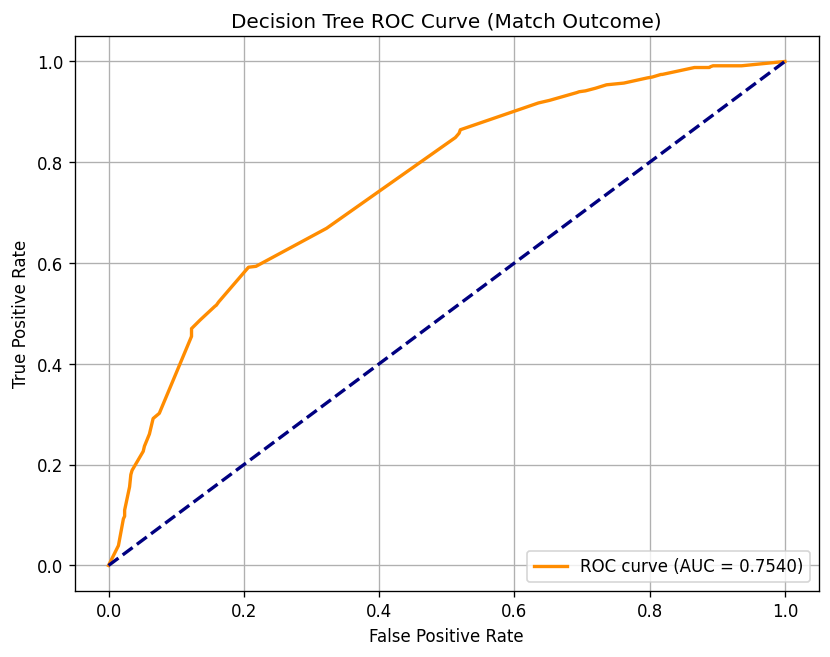

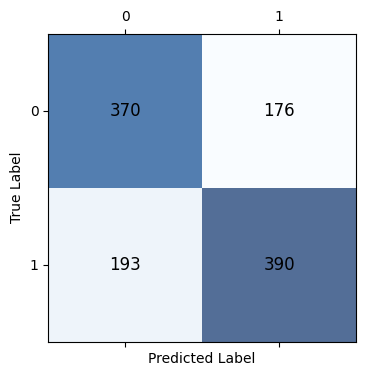

In [28]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 10)),
    'min_samples_leaf': list(range(1, 20, 2))
}

dt_model = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

GS = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

GS.fit(x_train, y_train)
print("Best Parameters Found:", GS.best_params_)

best_dt = DecisionTreeClassifier(**GS.best_params_, random_state=42)
best_dt.fit(x_train, y_train)

y_pred_dtree = best_dt.predict(x_test)
y_prob_dtree = best_dt.predict_proba(x_test)[:, 1]

evaluate_scores(y_pred_dtree, y_prob_dtree, y_test)
plot_roc_curve(y_prob_dtree, y_test, 'Decision Tree ROC Curve (Match Outcome)')
show_confusion(best_dt, x_test, y_test, y_pred_dtree)

KNN

Best Parameters Found: {'metric': 'euclidean', 'n_neighbors': 11}
Accuracy Score: 0.6900
ROC AUC Score: 0.7457
Precision Score: 0.7019
Recall Score: 0.6947
F1 Score: 0.6983

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.6775    0.6850    0.6812       546
           1     0.7019    0.6947    0.6983       583

    accuracy                         0.6900      1129
   macro avg     0.6897    0.6898    0.6898      1129
weighted avg     0.6901    0.6900    0.6900      1129



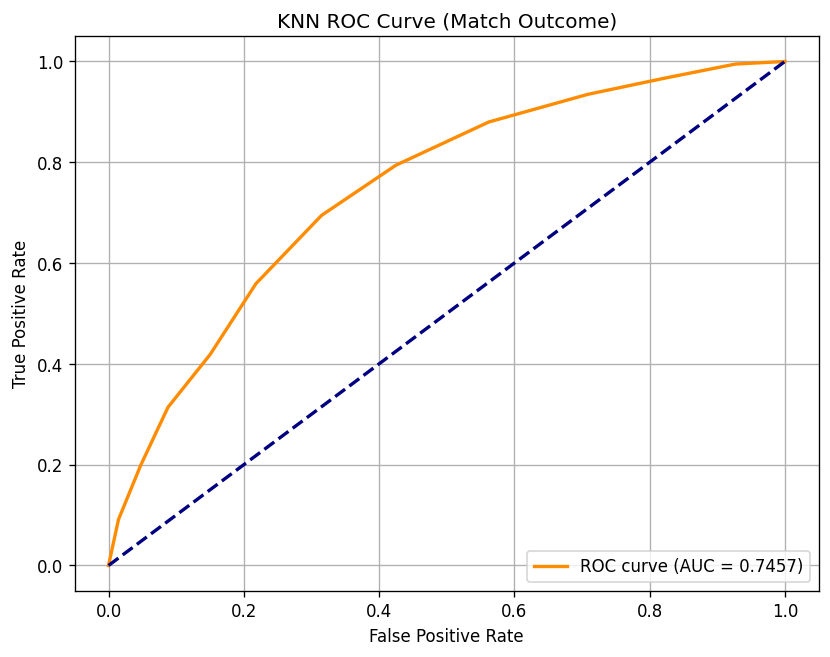

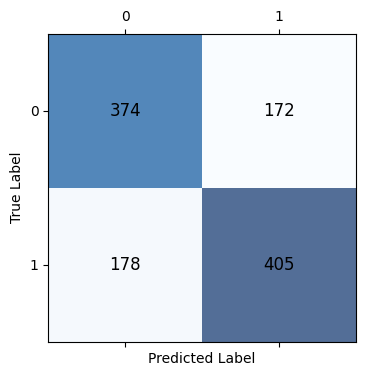

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(x_train, y_train)
print("Best Parameters Found:", grid_search.best_params_)

best_knn = grid_search.best_estimator_

y_pred_knn = best_knn.predict(x_test)
y_prob_knn = best_knn.predict_proba(x_test)[:, 1]

evaluate_scores(y_pred_knn, y_prob_knn, y_test)
plot_roc_curve(y_prob_knn, y_test, 'KNN ROC Curve (Match Outcome)')
show_confusion(best_knn, x_test, y_test, y_pred_knn)

MLP

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters (MLP): {'alpha': 0.0001, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001}
Best CV ROC AUC: 0.7659587169032004
Accuracy Score: 0.7086
ROC AUC Score: 0.7817
Precision Score: 0.7252
Recall Score: 0.7015
F1 Score: 0.7132

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.6920    0.7161    0.7039       546
           1     0.7252    0.7015    0.7132       583

    accuracy                         0.7086      1129
   macro avg     0.7086    0.7088    0.7085      1129
weighted avg     0.7091    0.7086    0.7087      1129



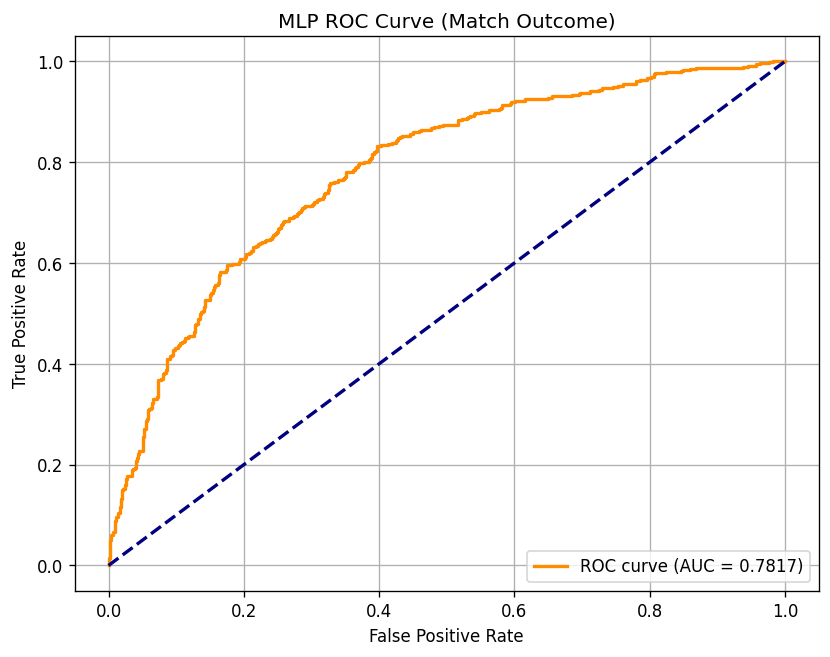

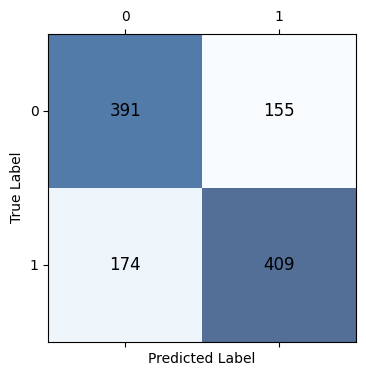

In [30]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


scaler_mlp = StandardScaler()
Xtr_mlp = scaler_mlp.fit_transform(x_train)
Xte_mlp = scaler_mlp.transform(x_test)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


mlp_base = MLPClassifier(
    activation="relu",
    solver="adam",
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42
)

param_grid_mlp = {
    "hidden_layer_sizes": [(64,), (128,), (128, 64), (256, 128)],
    "alpha": [1e-5, 1e-4, 1e-3],           # L2
    "learning_rate_init": [1e-3, 5e-4, 1e-4]
}

grid_mlp = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid_mlp,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid_mlp.fit(Xtr_mlp, y_train)
print("Best Parameters (MLP):", grid_mlp.best_params_)
print("Best CV ROC AUC:", grid_mlp.best_score_)

best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(Xte_mlp)
y_prob_mlp = best_mlp.predict_proba(Xte_mlp)[:, 1]

evaluate_scores(y_pred_mlp, y_prob_mlp, y_test)
plot_roc_curve(y_prob_mlp, y_test, "MLP ROC Curve (Match Outcome)")
show_confusion(best_mlp, Xte_mlp, y_test, y_pred_mlp)


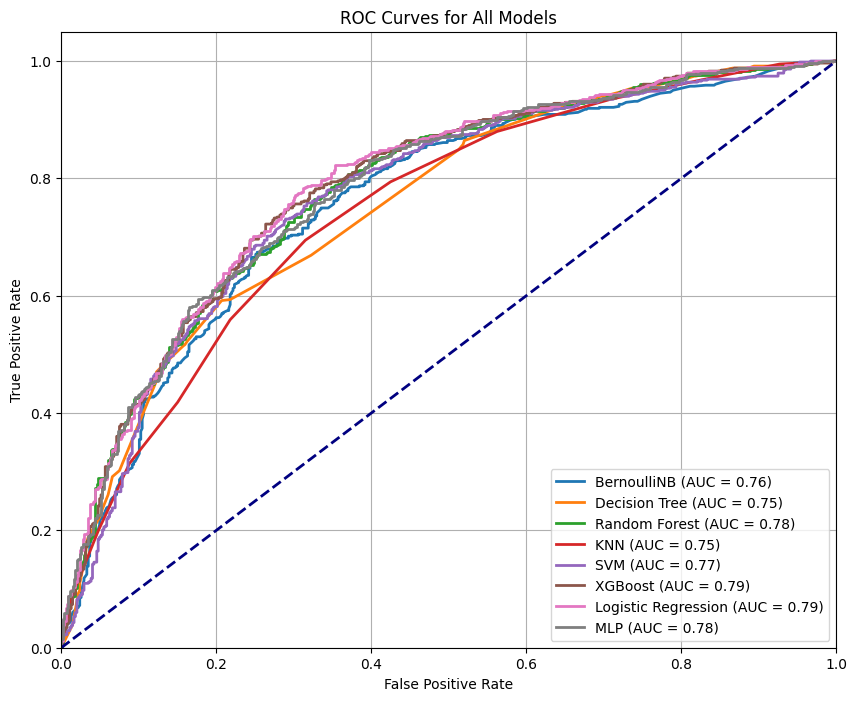

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


plt.figure(figsize=(10, 8))



# Naive Bayes
fpr_bys, tpr_bys, _ = roc_curve(y_test, y_prob_bys)
roc_auc_bys = auc(fpr_bys, tpr_bys)
plt.plot(fpr_bys, tpr_bys, lw=2, label='BernoulliNB (AUC = %.2f)' % roc_auc_bys)

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dtree)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, lw=2, label='Decision Tree (AUC = %.2f)' % roc_auc_dt)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_forest)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label='Random Forest (AUC = %.2f)' % roc_auc_rf)

# K-Nearest Neighbors
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, lw=2, label='KNN (AUC = %.2f)' % roc_auc_knn)

# Support Vector Machine
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, lw=2, label='SVM (AUC = %.2f)' % roc_auc_svm)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_XGB)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label='XGBoost (AUC = %.2f)' % roc_auc_xgb)

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, lw=2, label='Logistic Regression (AUC = %.2f)' % roc_auc_lr)

#MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.plot(fpr_mlp, tpr_mlp, lw=2, label='MLP (AUC = %.2f)' % roc_auc_mlp)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)


plt.show()
